### Create seizure labels by mining through log text file
Some notes:
- Seizures are labeled as "SZ ##" with the number increasing consecutively
- End of seizure indicated by a following "END"
- Not all seizure labels start with "SZ" but still indicate the number
- Because of ^ will look for seizures using the number 
- Clinical testing will also have an 'end' label - watch out for these

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# raw = pd.read_csv('a0f_6_log_notes_cleaned.txt',sep='\t',header=None)
path = '../DATA/cb4_7_log_notes_rm_header.txt'
with open(path, encoding="utf16", errors='ignore') as f:
    raw = pd.read_csv(f,sep='\t',header=None)
raw

,0,1,2
0,d1 08:09:04,NaN,Beginning of Recording
1,d1 08:09:04,NaN,Stop Recording
2,d1 08:09:04,NaN,Start Recording
3,d1 08:09:04,NaN,"Montage:cb4_2, External(Ref) Channel Status Se..."
4,d1 08:09:23,NaN,Start Recording
...,...,...,...
60,d2 06:31:14,NaN,SZ 41
61,d2 06:31:25,NaN,NCS
62,d2 07:06:23,NaN,Montage:Channel Test Referential
63,d2 07:06:27,NaN,Gain/Filter Change


In [102]:
# convert to seconds - start time = 8:13:25

def get_seconds(time):
    '''
    input time as tuple (hour, min, second) as integers
    returns time in seconds from 00:00 (midnight)
    '''
    return time[0]*60*60 + time[1]*60 + time[2]

In [108]:
# data start time 
t_start = get_seconds([8,13,25])

In [110]:
# put seizure events in new DF
# time is measured in seconds from ECoG recording start

sz_events = pd.DataFrame(columns=['day','sz number','time_start','time_end'])

sz_count = 14    # used to find seizure events
sz_flag = False  # used to find the correct 'end'

for row in range(raw.shape[0]):
    # get time in seconds from start ECoG recording
    timest = raw.iloc[row,0].split()[1].split(':')
    timest = [int(i) for i in timest] 
    day = raw.iloc[row,0].split()[0]
    if day == 'd1':
        timest = get_seconds(timest) - t_start
    if day == 'd2':
        timest = get_seconds(timest) + get_seconds([24,0,0]) - t_start
    
    # get string log
    log = raw.iloc[row,1]
    
    # seizure find
    if not sz_flag and (str(sz_count) in log):
        # print('sz #%i occurs at time %s' %(sz_count, timest))
        sz_flag = True
        
        # add to dataframe
        sz_events.loc[sz_count-14,'day'] = raw.iloc[row,0].split()[0]
        sz_events.loc[sz_count-14,'sz number'] = sz_count
        sz_events.loc[sz_count-14,'time_start'] = timest
        
    if sz_flag and (log.lower() == 'end'):
        # print('sz #%i ends at time %s' %(sz_count, timest))
        sz_events.loc[sz_count-14,'time_end'] = timest
        sz_count += 1
        sz_flag = False
sz_events

,day,sz number,time_start,time_end
0,d1,14,7919,8040
1,d1,15,8218,9114
2,d1,16,9893,10267
3,d1,17,10793,11568
4,d1,18,11999,12452
5,d1,19,12880,13388
6,d1,20,13684,20280
7,d1,21,23165,23329
8,d1,22,23895,24116
9,d1,23,24454,24691


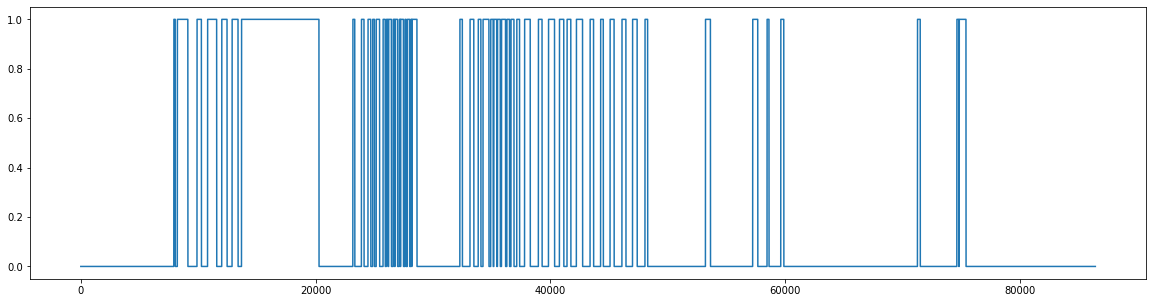

In [122]:
fs = 500 
t = np.arange(0,24*60*60,1/fs)
sz_bin = np.zeros(fs*24*60*60)  # 24 hours of time 

# iterate through sz DF and add 1 where there is seizure
for row in range(sz_events.shape[0]):
    t_start = sz_events.iloc[row,2]
    t_end = sz_events.iloc[row,3]
    sz_bin[t_start*fs:t_end*fs] = 1
    
# visualize
plt.figure(figsize=[20,5])
plt.plot(t,sz_bin)
    